In [1]:
# 1) 분석에 필요한 모듈 설치
!pip install konlpy
import konlpy.tag
from konlpy.tag import *
# hannanum = Hannanum()
# kkma = Kkma()
# komoran = Komoran()
# mecab = Mecab()
okt = Okt()
import re
import networkx as nx
import pandas as pd
from collections import Counter

In [2]:
# 2) 전처리 단계에서 생ㅇ성한 final_file.csv를 불러온다. 한글 데이터이므로 cp949로 인코딩한다.
# -> 경우에 따라 utf-8로 인코딩한다
# 3) csv파일에서 '민원등록일시' 및 '민원내용' 컬럼을 데이터프레임으로 저장한다

# 분석 대상 파일 불러오기
df = pd.read_csv('final_file.csv', encoding = 'cp949')
minwon_contents = df.get('민원내용')
minwon_date = df.get('민원등록일시')

In [3]:
# 4) 한글 텍스트 분석에 활용되는 불용어을 정리한 불용어 리스트 파일 stopwords.csv를 불러온다
# 5) 불용어 cxv 파일 'pattern'컬럼에 있는 불용어 리스트를 리스트 자료형으로 저장한다.

# 불용어 파일 불러오기
stopwords = pd.read_csv('stopwords.csv',encoding= 'cp949')
stop_words_list = [i for i in stopwords['pattern']]

len(stop_words_list)

861

In [4]:
# 6) Okt 모듈이 제공하는 okt.nouns() 함수를 이용해 '민원내용'; 컬럼의 텍스트 가운데 품사형이 명사인 단어만을 추출한다.
# 7) 명사 단어 중 2음절 이상인 단어만을 추출한다.
# 8) 명사 단어 중 수사를 제외한다.

from tqdm import notebook
from re import match # 전처리 위해서 정규표현식 관련 re 패키지 import
nouns = []
for sent in notebook.tqdm(minwon_contents, desc='iterate range 100') :
    for noun in okt.nouns(sent) :
        # 단어 전처리 : 2음절 이상, 수사 제외
        if len(str(noun)) >= 2 and not(match('^[0-9]', noun)) :
            nouns.append(noun)
nouns[:1]

iterate range 100:   0%|          | 0/7619 [00:00<?, ?it/s]

['불법']

In [5]:
len(nouns)

575837

In [7]:
# 9) 명사 품사 단어만을 추출한 민원 내용 가운데 불용어를 제거한다.

nouns2 = []
for noun in notebook.tqdm(nouns):
    if str(noun) not in stop_words_list:
        nouns2.append(noun)

  0%|          | 0/575837 [00:00<?, ?it/s]

In [8]:
len(nouns2)

341211

In [9]:
nouns2[:5]

['불법', '정차', '불법', '주차', '상세']

In [10]:
# 10) 민원 내용에 등장한 단어의 등장 빈도를 계산한다.
# 11) 등장 빈도가 잦은 Top 20개의 단어를 분석한다.

# 단어 빈도 분석
# 빈도 Top 20 단어 추출
from collections import Counter
num = 20
nouns_counter = Counter(nouns2)
minwon_top_nouns = dict(nouns_counter.most_common(num))
minwon_top_nouns

{'불편': 16036,
 '촬영': 11525,
 '원단': 10292,
 '생활': 9375,
 '저장': 7371,
 '기능': 7077,
 '개선': 6759,
 '한국': 6612,
 '개발': 6603,
 '정책': 6566,
 '제도': 6554,
 '용법': 6547,
 '역정보': 6547,
 '불법': 6388,
 '주차': 6207,
 '안내': 4985,
 '정보': 4951,
 '시스템': 4689,
 '유지관리': 4660,
 '사진촬영': 4310}

In [11]:
# 12) 등장 빈도 Top 20 단어를 Wordcolud 모듈을 이용하여 워드 클라우드 형태로 시각화 한다.
# 13) 시각화한 결과를 이미지 파일로 저장한다.

'''
일반적인 워드 클라우드 시각 표현 : wordcloud_a.jpg
빈도수가 가장 높은 단어를 중심으로 표현한 워드 클라우드 시각 표현 : wordcloud_b.jpg
'''

from wordcloud import WordCloud
wc = WordCloud(font_path='C:/Windows/Fonts/gulim.ttc', \
    background_color="white", \
    width=1000, \
    height=1000, \
    max_words=100, \
    max_font_size=300)

wc.generate_from_frequencies(dict(minwon_top_nouns))
wc.to_file("wordcloud_a.jpg")

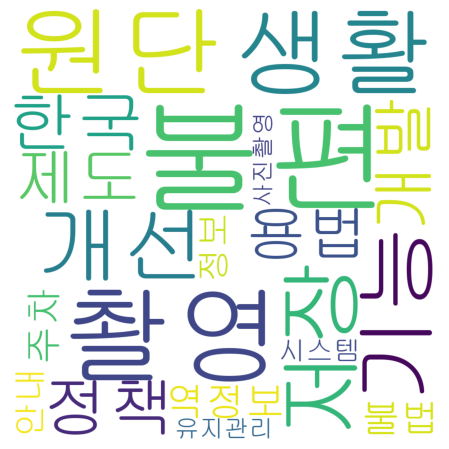

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

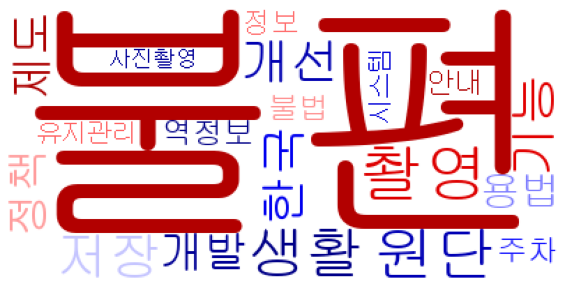

In [13]:
wc2 = WordCloud(font_path='C:/Windows/Fonts/gulim.ttc', \
                background_color='white',\
                max_font_size=400, \
                colormap='seismic').generate_from_frequencies(dict(minwon_top_nouns))

plt.figure(figsize=(10,8))
plt.imshow(wc2)
plt.axis('off')

plt.show()
wc2.to_file("wordcloud_b.jpg")

In [14]:
# 14) 민원에 등장한 단어 간 연결성을 보기 위한 SNA 분석을 진행한다. SNA 분석을 위해 단어의 출현 빈도에 따라 딕셔너리를 생성한다.

# 단어: ID(숫자가 낮을 수록 출현빈도가 높은 명사이다.) 딕셔너리 만들기
minwon_word2id = {w: i for i, w in enumerate(minwon_top_nouns.keys())}
minwon_word2id

{'불편': 0,
 '촬영': 1,
 '원단': 2,
 '생활': 3,
 '저장': 4,
 '기능': 5,
 '개선': 6,
 '한국': 7,
 '개발': 8,
 '정책': 9,
 '제도': 10,
 '용법': 11,
 '역정보': 12,
 '불법': 13,
 '주차': 14,
 '안내': 15,
 '정보': 16,
 '시스템': 17,
 '유지관리': 18,
 '사진촬영': 19}

In [15]:
# ID: 단어(숫자가 낮을 수록 출현빈도가 높은 명사이다.) 딕셔너리 만들기
minwon_id2word = {i: w for i, w in enumerate(minwon_top_nouns.keys())}
minwon_id2word

{0: '불편',
 1: '촬영',
 2: '원단',
 3: '생활',
 4: '저장',
 5: '기능',
 6: '개선',
 7: '한국',
 8: '개발',
 9: '정책',
 10: '제도',
 11: '용법',
 12: '역정보',
 13: '불법',
 14: '주차',
 15: '안내',
 16: '정보',
 17: '시스템',
 18: '유지관리',
 19: '사진촬영'}

In [16]:
# 15) 각 민원내용에 대해 민원에 포함된 명사 품사 단어를 추출하여 리스트형 자료로 저장한다.
# (*csv 파일에서 row로 나타나는 민원 각 항목)

#민원 건별로 문장 명사 추출
minwon_list = [i for i in minwon_contents]
minwon_list_nouns = []
for a in notebook.tqdm(minwon_list):
    list_nouns = okt.nouns(a)
    minwon_list_nouns.append(list_nouns)
minwon_list_nouns[:1]

  0%|          | 0/7619 [00:00<?, ?it/s]

[['불법',
  '정차',
  '신고',
  '불법',
  '주차',
  '상세',
  '위치',
  '설명',
  '삼계동',
  '푸르지오',
  '차',
  '경상남도',
  '김해시',
  '삼계동',
  '부근',
  '사진촬영',
  '시간',
  '안내',
  '행정',
  '공간',
  '정보',
  '체계',
  '유지',
  '보수',
  '사업',
  '단',
  '앱',
  '구동',
  '중',
  '바로',
  '촬영',
  '첨부',
  '사진',
  '신고',
  '갤러리',
  '첨부',
  '사진',
  '갤러리',
  '첨부',
  '사진',
  '앱',
  '실행',
  '시',
  '촬영',
  '사진',
  '갤러리',
  '저장',
  '사진',
  '첨부',
  '것',
  '촬영',
  '일시',
  '보장',
  '수',
  '참고',
  '생활',
  '불편',
  '스마트폰',
  '신고',
  '기능',
  '관련',
  '문의',
  '전화',
  '생활',
  '불편',
  '스마트폰',
  '신고',
  '기능',
  '관련',
  '문의',
  '전화']]

In [17]:
# 16) 14)에서 생성한 단어-id 딕셔너리를 행렬(matrix)로 만든다.
import numpy as np
minwon_adjMatrix = np.zeros((num,num), int)
for sentence in minwon_list_nouns:
    for wi, i in minwon_word2id.items():
        if wi in sentence:
            for wj, j in minwon_word2id.items():
                if i != j and wj in sentence:
                    minwon_adjMatrix[i][j] += 1
minwon_adjMatrix

array([[   0, 4511, 4430, 4713, 3770, 4687, 4422, 4435, 4435, 4432, 4431,
        4430, 4430, 3853, 2763, 4498, 4497, 4279, 4275, 4301],
       [4511,    0, 4262, 4510, 3770, 4508, 4233, 4267, 4262, 4262, 4263,
        4262, 4262, 3744, 2660, 4498, 4495, 4277, 4275, 4304],
       [4430, 4262,    0, 4430, 3596, 4430, 4397, 4430, 4430, 4430, 4430,
        4430, 4430, 3590, 2580, 4250, 4249, 4249, 4249, 4062],
       [4713, 4510, 4430,    0, 3773, 4684, 4416, 4435, 4430, 4431, 4431,
        4430, 4430, 3819, 2718, 4502, 4499, 4277, 4275, 4301],
       [3770, 3770, 3596, 3773,    0, 3770, 3582, 3597, 3596, 3596, 3596,
        3596, 3596, 3082, 2115, 3766, 3769, 3613, 3611, 3625],
       [4687, 4508, 4430, 4684, 3770,    0, 4401, 4437, 4430, 4431, 4430,
        4430, 4430, 3809, 2701, 4496, 4497, 4279, 4275, 4301],
       [4422, 4233, 4397, 4416, 3582, 4401,    0, 4398, 4400, 4398, 4397,
        4397, 4397, 3603, 2616, 4227, 4224, 4221, 4218, 4034],
       [4435, 4267, 4430, 4435, 3597, 443

In [18]:
# 17) 행렬에서 단어 간 인접도(adjacency)를 계산한다.

minwon_network = nx.from_numpy_matrix(minwon_adjMatrix)
list(minwon_network.adjacency())

[(0,
  {1: {'weight': 4511},
   2: {'weight': 4430},
   3: {'weight': 4713},
   4: {'weight': 3770},
   5: {'weight': 4687},
   6: {'weight': 4422},
   7: {'weight': 4435},
   8: {'weight': 4435},
   9: {'weight': 4432},
   10: {'weight': 4431},
   11: {'weight': 4430},
   12: {'weight': 4430},
   13: {'weight': 3853},
   14: {'weight': 2763},
   15: {'weight': 4498},
   16: {'weight': 4497},
   17: {'weight': 4279},
   18: {'weight': 4275},
   19: {'weight': 4301}}),
 (1,
  {0: {'weight': 4511},
   2: {'weight': 4262},
   3: {'weight': 4510},
   4: {'weight': 3770},
   5: {'weight': 4508},
   6: {'weight': 4233},
   7: {'weight': 4267},
   8: {'weight': 4262},
   9: {'weight': 4262},
   10: {'weight': 4263},
   11: {'weight': 4262},
   12: {'weight': 4262},
   13: {'weight': 3744},
   14: {'weight': 2660},
   15: {'weight': 4498},
   16: {'weight': 4495},
   17: {'weight': 4277},
   18: {'weight': 4275},
   19: {'weight': 4304}}),
 (2,
  {0: {'weight': 4430},
   1: {'weight': 4262},
 

Gulim


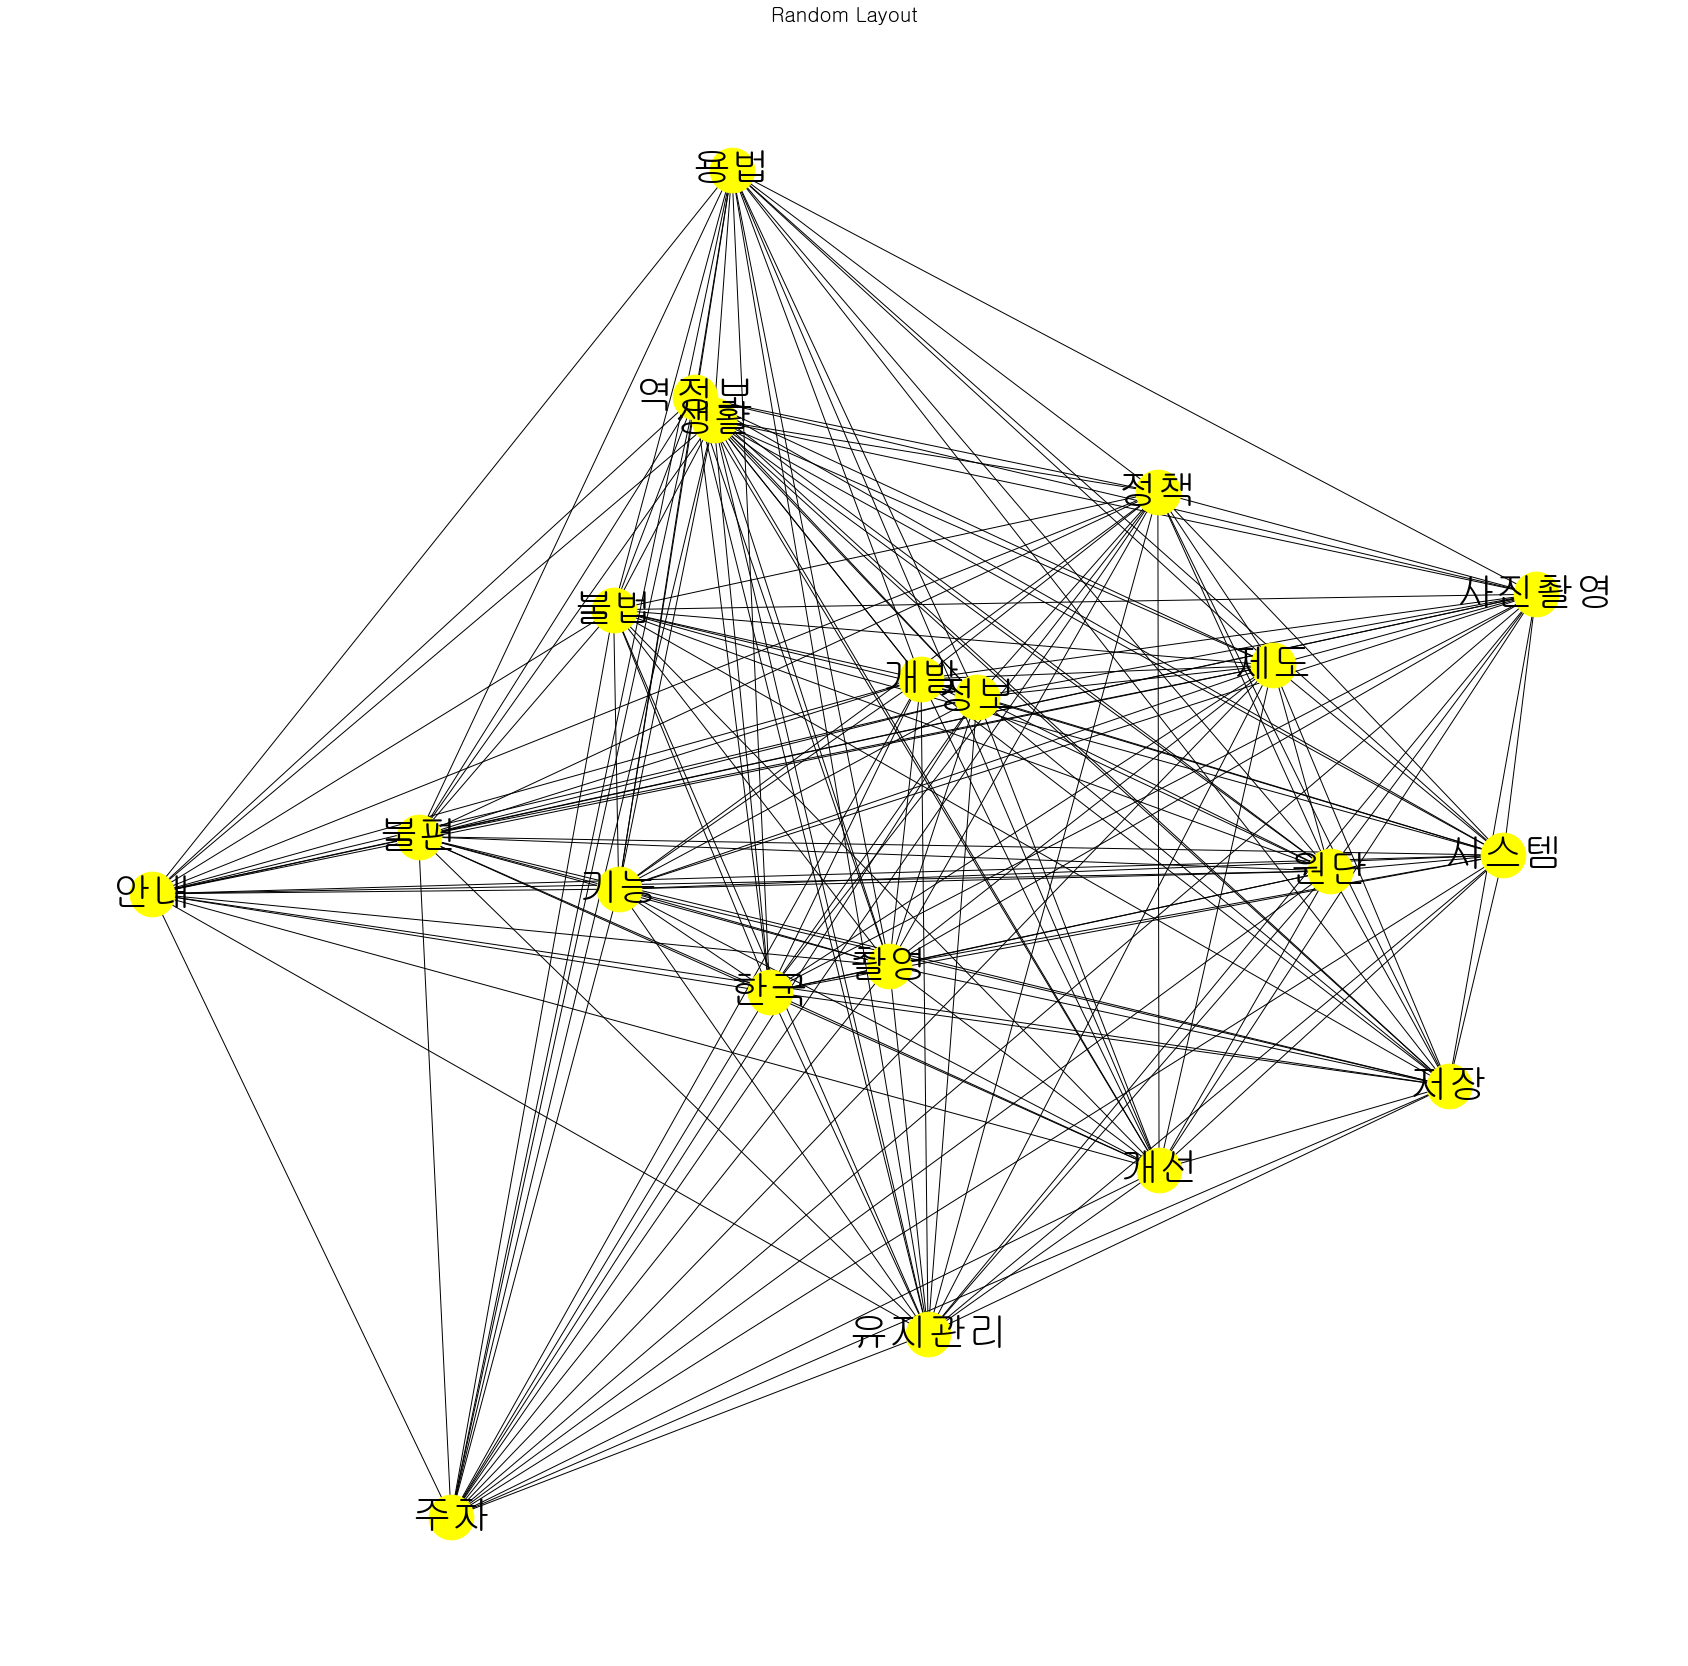

In [19]:
# 18) 단어 간 인접도 정보를 기반으로 단어 간 네트워크 연결망을 도식화 한다.

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
import networkx as nx

# 한글폰트설정
font_name = 'Gulim'
print(font_name)
plt.rc('font', family=font_name)

# 네트워크 시각화하기
fig = plt.figure()
fig.set_size_inches(30, 30)
ax = fig.add_subplot(1, 1, 1)
ax.axis("off")
option = {
        'node_color' : 'Yellow',
        'node_size' : 2000,
        'font_family': font_name,
        'font_size' : 40,
        'font_color' : 'black'
}

# nx.random_layout
plt.title('Random Layout', fontsize=20)
nx.draw(minwon_network,labels=minwon_id2word, ax = ax, **option)

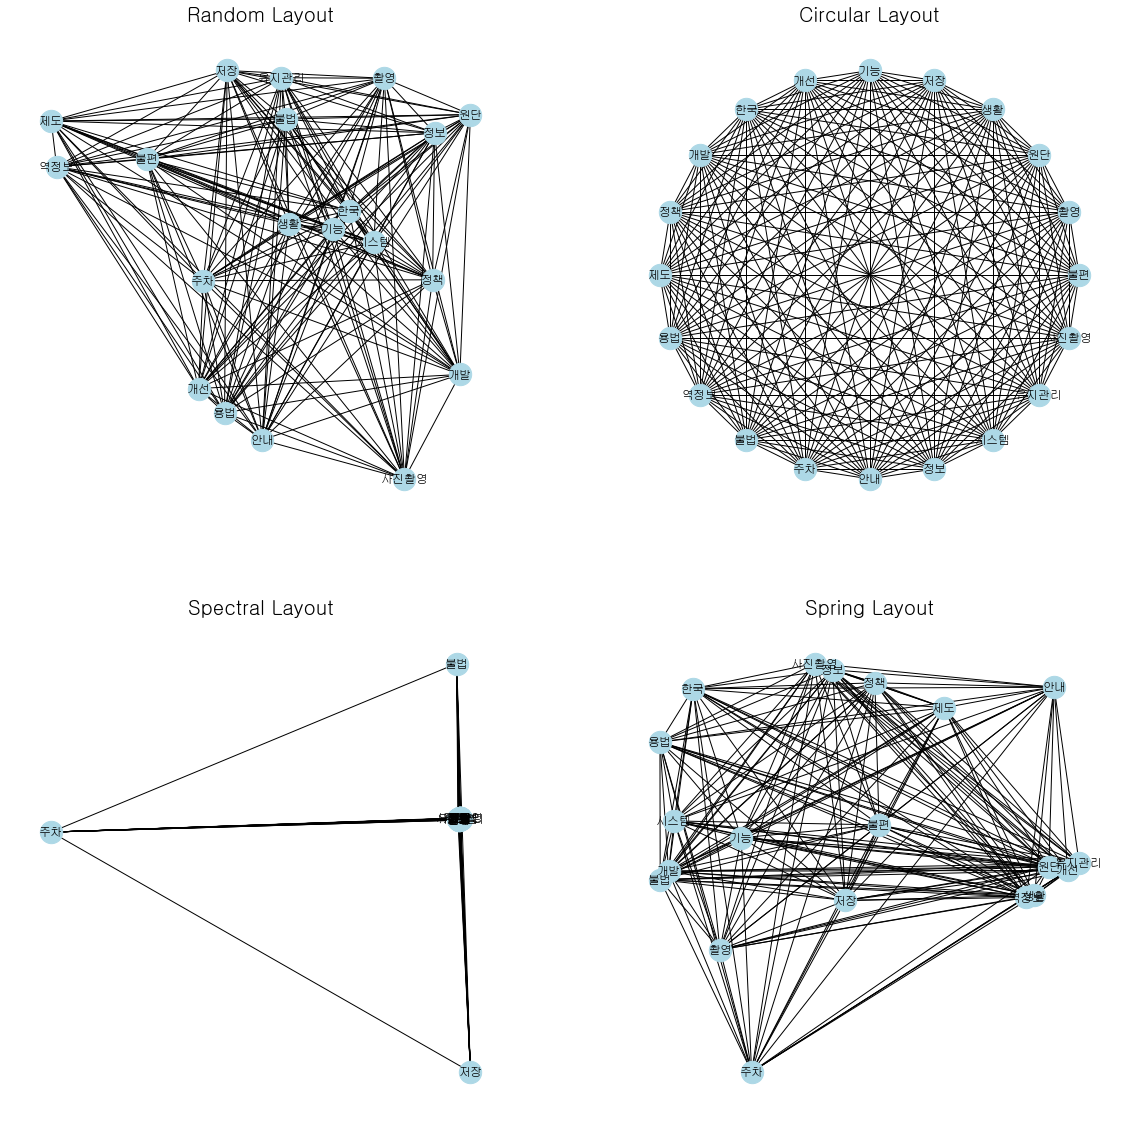

In [20]:
# 19) 다영한 sna 레이아웃을 적용하여 시각화 해본다.

fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
        'node_color' : 'lightblue',
        'node_size' : 500,
}

plt.subplot(221)
plt.title('Random Layout', fontsize=20)
nx.draw_random(minwon_network,labels=minwon_id2word, font_family=font_name, **option)
plt.subplot(222)
plt.title('Circular Layout', fontsize=20)
nx.draw_circular(minwon_network,labels=minwon_id2word, font_family=font_name, **option)
plt.subplot(223)
plt.title('Spectral Layout',fontsize=20)
nx.draw_spectral(minwon_network,labels=minwon_id2word, font_family=font_name, **option)
plt.subplot(224)
plt.title('Spring Layout',fontsize=20)
nx.draw_spring(minwon_network,labels=minwon_id2word, font_family=font_name, **option)